In [1167]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [1216]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [1217]:
df = pd.read_sql_query("SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE (cast(t.completedDateTime as Date) = cast(getdate() as Date)) AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service')\
    ORDER BY completedDateTime DESC", cnxn)

In [1218]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 29 2022 9:52AM,10,Eywa Pharma Inc.,Picking,Nelson Hurtado,9
1,Mar 29 2022 9:52AM,10,Eywa Pharma Inc.,Picking,Nelson Hurtado,9
2,Mar 29 2022 9:52AM,10,Eywa Pharma Inc.,Picking,Nelson Hurtado,9
3,Mar 29 2022 9:52AM,10,Bio-PRF,Count,Jackson Pierre,9
4,Mar 29 2022 9:52AM,10,Eywa Pharma Inc.,Picking,Nelson Hurtado,9


### Warehouse Activity

In [1219]:
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,137
1,102,4
2,12,35
3,16,116
4,18,55


In [1220]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [1221]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [1222]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,137
102,4
12,35
16,116
18,55


### Operations type

In [1223]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,28
1,Count,27
2,DONE RECEIVING,4
3,DRIVER CHECK IN,4
4,Finished Receiving,1


In [1224]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [1225]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,28
1,Count,27
2,DONE RECEIVING,4
3,DRIVER CHECK IN,4
4,Finished Receiving,1


In [1226]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,28
Count,27
DONE RECEIVING,4
DRIVER CHECK IN,4
Finished Receiving,1


### Operations per Hour

In [1227]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,8
1,7,50
2,8,288
3,9,342


In [1228]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [1229]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,8
7,50
8,288
9,342


# PICKING

In [1230]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [1231]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Angel Luna,8,4
1,Angel Luna,9,6
2,Angela Pena,9,45
3,Brad Bacchetti,8,6
4,Brad Bacchetti,9,12


In [1232]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9
employee,,,
Angel Luna,0.0,4.0,6.0
Angela Pena,0.0,0.0,45.0
Brad Bacchetti,0.0,6.0,12.0
Carlos Gomez,0.0,12.0,0.0
Ernest Ferguson,0.0,0.0,3.0


### Save in JSON File

In [1234]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Angel Luna,Angela Pena,Brad Bacchetti,Carlos Gomez,Ernest Ferguson,Gregory Watts,Hugo Gonzales,Isaiah Lyng,Jackson Pierre,Juan Morales,...,Marzetta Bracken,Micah Powers,Nelson Hurtado,Omar Robles,Raul Bejarano,Sergio Piura,Shannon Williamson,Shawn Saunders,Sujelin Soto-Orta,Wendy Medrano
7,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
8,4.0,0.0,6.0,12.0,0.0,6.0,27.0,0.0,0.0,0.0,...,0.0,0.0,21.0,0.0,14.0,0.0,0.0,2.0,20.0,29.0
9,6.0,45.0,12.0,0.0,3.0,12.0,0.0,8.0,6.0,1.0,...,6.0,3.0,16.0,1.0,0.0,1.0,22.0,18.0,10.0,32.0


# Picking By Warehouse Function

In [1186]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [1187]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# Picking and W-10

In [1188]:
# Filtered by Picking and Warehouse
df_picking_10 = df_picking[df_picking['warehouse'] == '10']
df_picking_10.head()

,Date,warehouse,project,operationCode,employee,Hour
2,Mar 29 2022 9:41AM,10,"SD Head USA, LLC",Picking,Sergio Piura,9
68,Mar 29 2022 9:31AM,10,"Amcyte Pharma, Inc.",Picking,Nelson Hurtado,9
398,Mar 29 2022 8:42AM,10,"Methapharm, Inc.",Picking,Carlos Gomez,8
400,Mar 29 2022 8:41AM,10,"Methapharm, Inc.",Picking,Carlos Gomez,8
401,Mar 29 2022 8:41AM,10,"Methapharm, Inc.",Picking,Carlos Gomez,8


In [1189]:
# Grouped by Employee and Hour
df_picking_10_grouped = df_picking_10.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_10_grouped.reset_index(inplace=True)
df_picking_10_grouped.head()

,employee,Hour,operationCode
0,Carlos Gomez,8,12
1,Hugo Gonzales,8,27
2,Nelson Hurtado,8,21
3,Nelson Hurtado,9,1
4,Sergio Piura,9,1


In [1190]:
# Pivot
df_picking_10_pivoted = df_picking_10_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_10_pivoted = df_picking_10_pivoted.fillna(0)
df_picking_10_pivoted = df_picking_10_pivoted.rename_axis(None, axis=1)
#df_picking_10_pivoted.reset_index(inplace=True)

df_picking_10_pivoted

,8,9
employee,,
Carlos Gomez,12.0,0.0
Hugo Gonzales,27.0,0.0
Nelson Hurtado,21.0,1.0
Sergio Piura,0.0,1.0


### Save in JSON File

In [1191]:
# Save into JSON
#pickers_W10 = df_picking_10_pivoted.T
#pickers_W10.to_json('data/pickers_w10.json')
#pickers_W10

In [1192]:
df_picking_10_pivoted_T = df_picking_10_pivoted.T
df_picking_10_pivoted_T

employee,Carlos Gomez,Hugo Gonzales,Nelson Hurtado,Sergio Piura
8,12.0,27.0,21.0,0.0
9,0.0,0.0,1.0,1.0


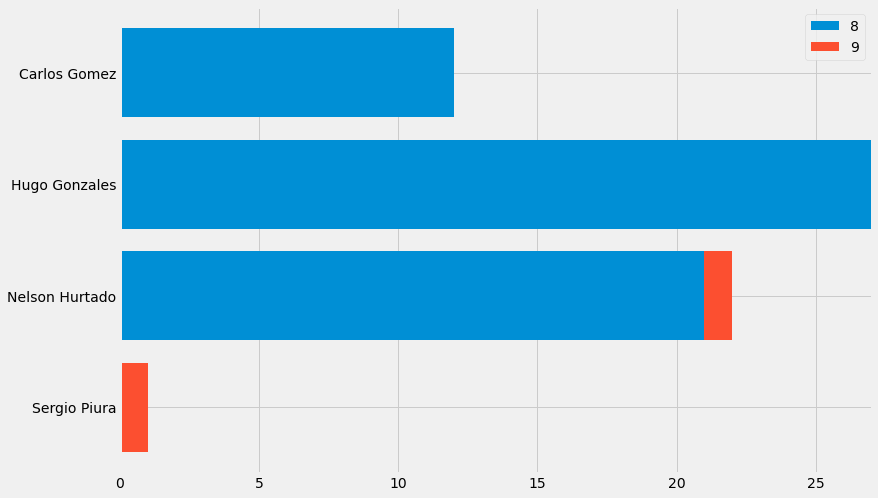

In [1193]:
# Horizontal Chart
labels = df_picking_10_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

left_hour = [0.] * df_picking_10_pivoted_T.shape[1]

for i in df_picking_10_pivoted_T.index:
    ax.barh(labels, df_picking_10_pivoted_T.loc[i].values, left = left_hour)
    left_hour += df_picking_10_pivoted_T.loc[i].values

ax.legend(df_picking_10_pivoted_T.index)
plt.gca().invert_yaxis()
plt.show()

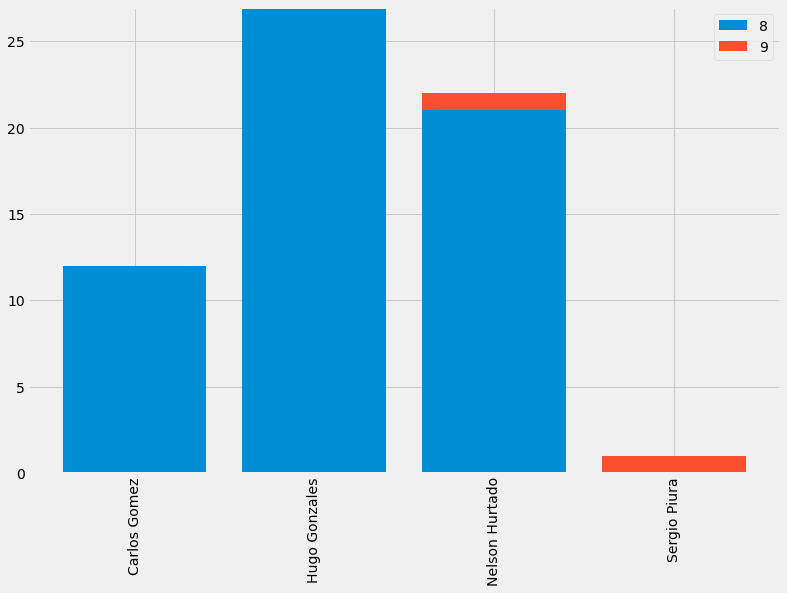

In [1194]:
# Vertical Chart
labels = df_picking_10_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

bottom_hour = [0.] * df_picking_10_pivoted_T.shape[1]

for i in df_picking_10_pivoted_T.index:
    ax.bar(labels, df_picking_10_pivoted_T.loc[i].values, bottom = bottom_hour)
    bottom_hour += df_picking_10_pivoted_T.loc[i].values

ax.legend(df_picking_10_pivoted_T.index)

plt.xticks(rotation=90)
plt.show()

# Picking and W-20

In [1195]:
# Filtered by Picking and Warehouse
df_picking_20 = df_picking[df_picking['warehouse'] == '20']
df_picking_20.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 29 2022 9:41AM,20,"ACI Healthcare USA, Inc.",Picking,Gregory Watts,9
11,Mar 29 2022 9:38AM,20,Reliable 1 Laboratories LLC,Picking,Wendy Medrano,9
12,Mar 29 2022 9:38AM,20,Reliable 1 Laboratories LLC,Picking,Shawn Saunders,9
13,Mar 29 2022 9:38AM,20,"ACI Healthcare USA, Inc.",Picking,Gregory Watts,9
15,Mar 29 2022 9:38AM,20,Reliable 1 Laboratories LLC,Picking,Shawn Saunders,9


In [1196]:
# Grouped by Employee and Hour
df_picking_20_grouped = df_picking_20.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_20_grouped.reset_index(inplace=True)
df_picking_20_grouped.head()

,employee,Hour,operationCode
0,Ernest Ferguson,9,3
1,Gregory Watts,7,3
2,Gregory Watts,8,6
3,Gregory Watts,9,8
4,Maria Ramos,8,25


In [1197]:
# Pivot
df_picking_20_pivoted = df_picking_20_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_20_pivoted = df_picking_20_pivoted.fillna(0)
df_picking_20_pivoted = df_picking_20_pivoted.rename_axis(None, axis=1)
#df_picking_10_pivoted.reset_index(inplace=True)

df_picking_20_pivoted

,7,8,9
employee,,,
Ernest Ferguson,0.0,0.0,3.0
Gregory Watts,3.0,6.0,8.0
Maria Ramos,0.0,25.0,19.0
Marzetta Bracken,0.0,0.0,6.0
Micah Powers,0.0,0.0,3.0
Shawn Saunders,0.0,2.0,15.0
Wendy Medrano,8.0,29.0,32.0


### Save in JSON File

In [1198]:
#pickers_W20 = df_picking_20_pivoted.T
#pickers_W20.to_json('data/pickers_w20.json')
#pickers_W20

In [1199]:
df_picking_20_pivoted_T = df_picking_20_pivoted.T
df_picking_20_pivoted_T

employee,Ernest Ferguson,Gregory Watts,Maria Ramos,Marzetta Bracken,Micah Powers,Shawn Saunders,Wendy Medrano
7,0.0,3.0,0.0,0.0,0.0,0.0,8.0
8,0.0,6.0,25.0,0.0,0.0,2.0,29.0
9,3.0,8.0,19.0,6.0,3.0,15.0,32.0


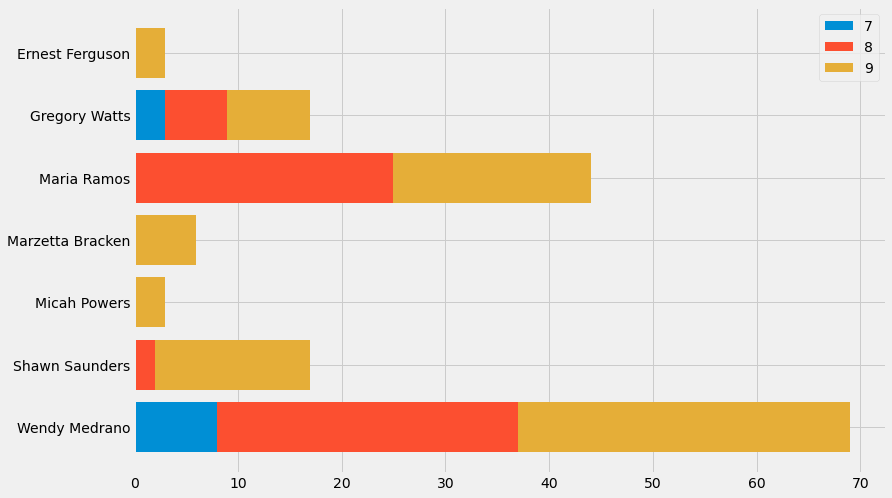

In [1200]:
# Horizontal Chart
labels = df_picking_20_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

left_hour = [0.] * df_picking_20_pivoted_T.shape[1]

for i in df_picking_20_pivoted_T.index:
    ax.barh(labels, df_picking_20_pivoted_T.loc[i].values, left = left_hour)
    left_hour += df_picking_20_pivoted_T.loc[i].values

ax.legend(df_picking_20_pivoted_T.index)
plt.gca().invert_yaxis()
plt.show()

In [1201]:
df_picking_20_pivoted_T.index

Int64Index([7, 8, 9], dtype='int64')

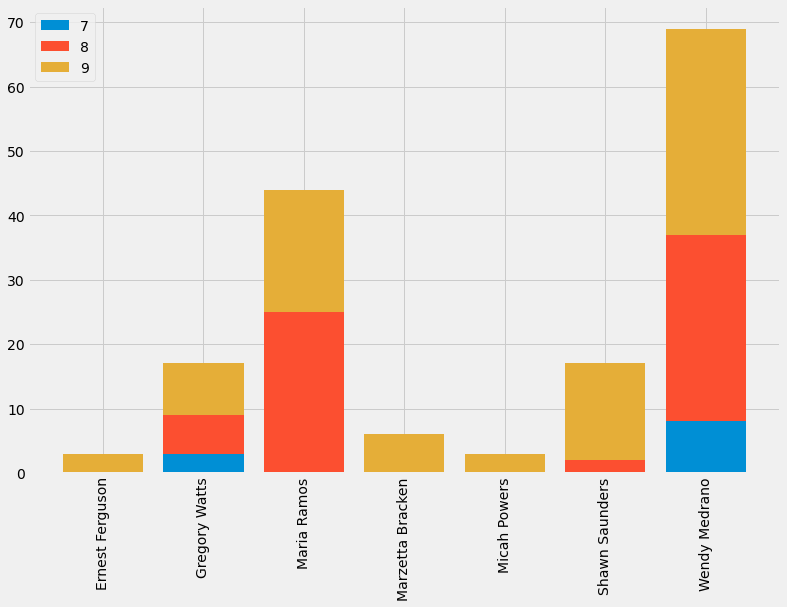

In [1202]:
# Vertical Chart
labels = df_picking_20_pivoted_T.columns
fig, ax = plt.subplots(figsize=(12,8))

bottom_hour = [0.] * df_picking_20_pivoted_T.shape[1]

for i in df_picking_20_pivoted_T.index:
    ax.bar(labels, df_picking_20_pivoted_T.loc[i].values, bottom = bottom_hour)
    bottom_hour += df_picking_20_pivoted_T.loc[i].values

ax.legend(df_picking_20_pivoted_T.index)

plt.xticks(rotation=90)
plt.show()

# QUERY 02: Open Outbounds

In [1203]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [1204]:
df_02

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447
...,...,...,...,...
7590,18,Hush Hush,HH5787,2022-03-29 09:32:24.840
7591,10,ISDIN Corporation,0085555220,2022-03-29 09:35:09.723
7592,18,Hush Hush,HH5791,2022-03-29 09:38:35.370
7593,19,ACG North America LLC,ACG-SAMPLE32922,2022-03-29 09:38:36.260


In [1205]:
df_02.dtypes

warehouse                     object
project                       object
shipment_number               object
createdSysDateTime    datetime64[ns]
dtype: object

In [1206]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1707 days 00:34:22.810528
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,910 days 22:53:21.864528
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,865 days 17:06:47.214528
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,796 days 20:23:18.944528
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,796 days 20:23:18.560528
...,...,...,...,...,...
7590,18,Hush Hush,HH5787,2022-03-29 09:32:24.840,0 days 00:11:07.167528
7591,10,ISDIN Corporation,0085555220,2022-03-29 09:35:09.723,0 days 00:08:22.284528
7592,18,Hush Hush,HH5791,2022-03-29 09:38:35.370,0 days 00:04:56.637528
7593,19,ACG North America LLC,ACG-SAMPLE32922,2022-03-29 09:38:36.260,0 days 00:04:55.747528


In [1207]:
df_02.dtypes

warehouse                      object
project                        object
shipment_number                object
createdSysDateTime     datetime64[ns]
age_order             timedelta64[ns]
dtype: object

In [1208]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1707 days 00:34:22.810528,1707,0
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,910 days 22:53:21.864528,910,22
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,865 days 17:06:47.214528,865,17
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,796 days 20:23:18.944528,796,20
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,796 days 20:23:18.560528,796,20
...,...,...,...,...,...,...,...
7590,18,Hush Hush,HH5787,2022-03-29 09:32:24.840,0 days 00:11:07.167528,0,0
7591,10,ISDIN Corporation,0085555220,2022-03-29 09:35:09.723,0 days 00:08:22.284528,0,0
7592,18,Hush Hush,HH5791,2022-03-29 09:38:35.370,0 days 00:04:56.637528,0,0
7593,19,ACG North America LLC,ACG-SAMPLE32922,2022-03-29 09:38:36.260,0 days 00:04:55.747528,0,0


In [1209]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [1210]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [1211]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [1212]:
df_02_grouped

,orders
age_group,
24 Hours,962
48 Hours,28
72 Hours,170
1 Week,822
1 Month,963
2 Months,743
3 Months,666
1 Year,2184
2 Years,996


### Save in JSON File

In [1213]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,962
48 Hours,28
72 Hours,170
1 Week,822
1 Month,963
2 Months,743
3 Months,666
1 Year,2184
2 Years,996


<AxesSubplot:ylabel='age_group'>

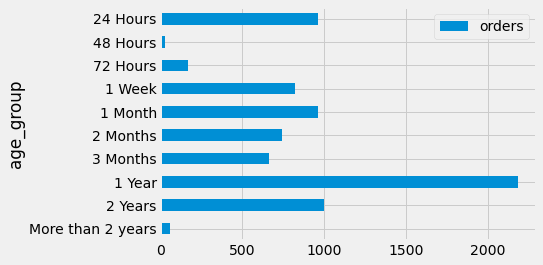

In [1214]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

In [1215]:
# Close connection
cnxn.close()